> Created on Mon Jun 12 15:03:15 2023 @author: Richie Bao-caDesign设计(cadesign.cn)

# 3.6 时空序列

## 3.6.1 从 RNN 到 LSTM

### 3.6.1.1 RNN（Recurrent Neural Networks）

当处理序列数据（sequential data），例如*时空序列分析*部分提到的 AoT 城市环境传感器时间序列数据，*动态街景视觉感知*部分提到的用于无人驾驶场景下计算机视觉算法评测数据集 KITTI，*空间动力学——空间马尔可夫链*部分提到的历年 MCD12Q1_v006 lulc 数据，及各类型连续时间的遥感影像数据、实时城市活动动态（交通流、信息流、社交媒体等各类热力图）等，其各样本数据点（data point）并不是独立的，例如当前污染气体$CO_2$的浓度依赖于前一时刻或之前更长时间段内$CO_2$的浓度（时间相关），沿城市道路后一位置点的城市属性（例如 POI、人口密度、LULC 等）依赖于前一位置点的属性（空间相关）等，那么处理数据点之间具有独立性假设的一般标准的神经网络用于序列数据则会丢失网络的整个状态，即丢失数据点之间的时空相关性。

在*空间马尔可夫链*部分解释了经典离散（时间）马尔可夫链（Discrete-time Markov chain，D(T)MC）和空间马尔科夫 （Spatial Markov），模拟了观测序列中状态之间的转换；在*马尔可夫随机场（MRF）和城市降温模型的 MRF 推理*部分解释了马尔可夫网（马尔科夫随机场）。发展于马尔可夫链的隐马尔可夫模型（Hidden Markov Model），用来描述含有隐含未知参数（不可观测到的状态）的马尔可夫过程，将观测到的序列建模为依赖于未观测到的一系列状态的概率。但是传统的马尔可夫模型的计算量与各随机变量的状态数量呈指数增长，且每个隐藏状态通常只能依赖于上一个状态，而递归（循环）神经网络（Recurrent Neural Networks，RNN）可以捕获更长宽度（long-range）语境/上下文（context）下的时空依赖性（其任何时刻的隐藏状态都可以包含来自任意长的语境窗口（arbitrarily long context window））；并且网络的计算量并不会指数增长<sup>[Lipton, Z. C., Berkowitz, J. & Elkan, C. A Critical Review of Recurrent Neural Networks for Sequence Learning. (2015).]</sup>。

RNN 一般为前馈神经网络（feedforward neural networks），从算法解析的图中可以观察到，在$t$时刻（时间步，或空间位置），隐藏节点（hidden node）$h_t$（隐藏状态）的值来源于两个分支，一个是当前时刻的数据点输入$x_t$乘以权重值$w_{ih}$加上偏置$b_{ih}$；另一个分支是前一时刻隐藏状态的值乘以权重$w_{hh}$加上偏置$b_{hh}$。通过激活函数（通常用 Relu 和 Tanh 实现非线性）的两个分支的和即为当前时刻隐藏状态的值，各个输入的数据点和隐藏层的值计算同上。对于开始时刻输入的隐藏状态的值通常配置为张量0。这样就构建了当前时刻的状态与其前一时刻状态的关联。各时刻的输出值为对应隐藏状态值乘以权重$w_{ho}$加上偏置$b_{ho}$获得。对于输入序列的每一个元素（数据点），各层计算公式可以写作$h_t = \tanh(x_t W_{ih}^T + b_{ih} + h_{t-1}W_{hh}^T + b_{hh})$<sup>[PyTorch-RNN, <https://pytorch.org/docs/stable/generated/torch.nn.RNN.html>.]</sup>，式中，$h_t$是当前时刻$t$的隐藏状态（hidden state），$x_t$是当前时刻$t$的输入，$h_{t-1}$是前一时刻$t-1$隐藏状态或者为时刻 0 时的初始状态。

<img src="../imgs/3_6/3_6_02.jpg" height='auto' width=800 title="caDesign"> 

In [1]:
%load_ext autoreload 
%autoreload 2 
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
    
import usda.data_visual as usda_vis    
import usda.utils as usda_utils
import usda.models as usda_models

import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

* 多层 RNN

`PyTorch`库包含有 RNN 网络，下述代码配置了其输入参数`num_layers=2`，该参数为递归（循环）的层数，意味着两个 RNN 堆叠在一起构成叠合的 RNN（stackedRNN），第2个RNN以第1个RNN的输出为输入，第2个RNN的输出为最终的输出，如下网络结构示例图<sup>[Deep Recurrent Nets character generation demo, <https://cs.stanford.edu/people/karpathy/recurrentjs/>]</sup>。

<img src="../imgs/3_6/3_6_04.jpg" height='auto' width=600 title="caDesign"> 

以一个文本序列`neural`输入为例，首先将文本字符串转换为整数标签，并通过除以最大字符标签数将其标准化，且调整形状为`(1,6,1)`，为1个样本下有6个数据点，每次输入一个数据点，即特征数参数`input_size`为1。并配置隐藏状态的特征数`hidden_size`为5，递归层数`num_layers`为2，实例初始化`nn.RNN`后，输入`neural`整数化的一个样本。从输出结果可以观察到，`output`即为第2个 RNN 的输出结果。

首先构建样本数据。

In [20]:
raw_text=r'neural'.lower()
chars=sorted(list(set(raw_text)))
char_to_int=dict((c, i) for i, c in enumerate(chars))

X=torch.tensor([char_to_int[char] for char in raw_text],dtype=torch.float32).reshape(1,len(raw_text),1)/len(chars)
print(X.shape,'\n',X)

torch.Size([1, 6, 1]) 
 tensor([[[0.5000],
         [0.1667],
         [0.8333],
         [0.6667],
         [0.0000],
         [0.3333]]])


激活函数默认配置为`Tanh`，对应参数`nonlinearity`，值域为-1到1。

In [21]:
input_size=1
hidden_size=3
num_layers=2

rnn=nn.RNN(input_size, hidden_size, num_layers)
print(rnn)
h0=torch.randn(num_layers, X.shape[1], hidden_size)
output, hn=rnn(X, h0)
print(output.shape,hn.shape)
print(output,'\n','-'*50,'\n',hn)

RNN(1, 3, num_layers=2)
torch.Size([1, 6, 3]) torch.Size([2, 6, 3])
tensor([[[-0.4898, -0.0451,  0.5158],
         [-0.2987,  0.5905,  0.2265],
         [-0.0492, -0.7288, -0.2116],
         [-0.4321, -0.2413, -0.7025],
         [-0.4563,  0.5862,  0.0823],
         [-0.0016,  0.0199,  0.2315]]], grad_fn=<StackBackward0>) 
 -------------------------------------------------- 
 tensor([[[-0.1867,  0.0805,  0.5953],
         [-0.5911,  0.9160,  0.3573],
         [-0.7828,  0.2346,  0.8274],
         [-0.5516,  0.2513,  0.8900],
         [-0.7596,  0.9361,  0.2073],
         [-0.4027,  0.8579,  0.4963]],

        [[-0.4898, -0.0451,  0.5158],
         [-0.2987,  0.5905,  0.2265],
         [-0.0492, -0.7288, -0.2116],
         [-0.4321, -0.2413, -0.7025],
         [-0.4563,  0.5862,  0.0823],
         [-0.0016,  0.0199,  0.2315]]], grad_fn=<StackBackward0>)


* 双向递归神经网络 BRNN

对于许多序列标记任务，不仅是当前时刻从过往时刻的数据点获得信息，往往也需要从将来时刻的数据点获得信息，因此Schuster, M. 等人提出了双向递归神经网络（Bidirectional Recurrent Neural Networks，BRNN），可以使用特定时间范围内过去和未来的所有可用输入信息进行训练<sup>[Schuster, M. & Paliwal, K. K. Bidirectional Recurrent Neural Networks. IEEE TRANSACTIONS ON SIGNAL PROCESSING vol. 45 (1997).]</sup>。BRNN 的基本思想是将每个训练序列向前和向后表述为两个独立的递归隐藏层，这两个隐藏层都连接到同一个输出层，如图<sup>[Graves, A. Supervised Sequence Labelling with Recurrent Neural Networks. in Studies in Computational Intelligence (2012).]26</sup>。

<img src="../imgs/3_6/3_6_06.jpg" height='auto' width=600 title="caDesign"> 

`PyTorch`提供的 RNN 方法中可以直接配置`bidirectional=True`实现 BRNN。隐藏节点初始化的张量`h_0`形状为$(D * num_layers,H_{out})$，当配置 RNN 网络为 BRNN 时，其$D=2$。下述试验配置`num_layers=1`，可以发现训练序列的每一节点的输出值`output`为隐藏状态的2倍；隐藏状态`hn`包含合并的前向和后向两个独立隐藏层的张量。

In [11]:
num_layers=1
rnn=nn.RNN(input_size, hidden_size, num_layers,bidirectional=True)
print(rnn)
h0=torch.randn(num_layers*2, X.shape[1], hidden_size)
output, hn=rnn(X, h0)
print(output.shape,hn.shape)
print(output,'\n','-'*50,'\n',hn)

RNN(1, 3, bidirectional=True)
torch.Size([1, 6, 6]) torch.Size([2, 6, 3])
tensor([[[-0.0948,  0.8778, -0.6792, -0.4503,  0.2629,  0.1734],
         [-0.2018,  0.7779, -0.1665, -0.9079,  0.8410,  0.4358],
         [ 0.3702,  0.5908,  0.4314,  0.3850, -0.6145,  0.1485],
         [ 0.8645,  0.0013, -0.4648, -0.7760,  0.0113,  0.8661],
         [-0.0232,  0.4756,  0.6359,  0.2150, -0.0758, -0.1035],
         [ 0.8035, -0.1572,  0.0789,  0.8305, -0.9462,  0.4790]]],
       grad_fn=<CatBackward0>) 
 -------------------------------------------------- 
 tensor([[[-0.0948,  0.8778, -0.6792],
         [-0.2018,  0.7779, -0.1665],
         [ 0.3702,  0.5908,  0.4314],
         [ 0.8645,  0.0013, -0.4648],
         [-0.0232,  0.4756,  0.6359],
         [ 0.8035, -0.1572,  0.0789]],

        [[-0.4503,  0.2629,  0.1734],
         [-0.9079,  0.8410,  0.4358],
         [ 0.3850, -0.6145,  0.1485],
         [-0.7760,  0.0113,  0.8661],
         [ 0.2150, -0.0758, -0.1035],
         [ 0.8305, -0.9462, 

### 3.6.1.2 LSTM（long short-term memory）

对于上述标准的 RNN 模型，输出值与隐藏状态的权重$w_{hh}$和数据点数$N_{data points}$有$w_{hh}^{N_{data points}}$指数增长关系。因此如果隐藏状态的权重大于1，当数据点不断增多时，可能引起梯度爆炸（Gradient explosion）；如果隐藏状态的权重小于1，则可能引起梯度消失（Gradient vanishing）。并且，如果时间跨度很大，当前时刻的状态则并不能学习到较早时刻的输入信息，因此 Hochreiter, S.和 Schmidhuber, J. 提出了长短时记忆网络（long short-term memory，LSTM）<sup>[Hochreiter, S., & Schmidhuber, J. (1997). Long Short-Term Memory. Neural Computation, 9(8), 1735–1780. doi:10.1162/neco.1997.9.8.1735]</sup>。LSTM 类似于一个带有隐藏层的标准递归神经网络，但是隐藏层中的每个普通节点被一个记忆单元（memory cell）所取代，即 LSTM 单元（LSTM unit）。每个记忆单元包含一个具有固定权重为1的自连接递归边（self-connected recurrent edge），确保梯度可以跨越多个时间点而不会消失或爆炸，为含符号$c$的顶部边表示的长时记忆（Long-Term Memory），即单元状态（Cell State），如图<sup>[Yu, Y., Si, X., Hu, C. & Zhang, J. A review of recurrent neural networks: Lstm cells and network architectures. Neural Computation vol. 31 1235–1270 Preprint at https://doi.org/10.1162/neco_a_01199 (2019).][Long short-term memory (Wikipedia), <https://en.wikipedia.org/wiki/Long_short-term_memory>]</sup>；短时记忆（Short-Term Memory）为含符号$h$，有权重的底部边，即隐藏状态（Hidden State）。

<img src="../imgs/3_6/3_6_07.jpg" height='auto' width='auto' title="caDesign"> 

LSTM 通过在记忆单元中引入门（gate）机制控制特征的流转和过滤，解决“长期依赖（long-term dependencies）问题”。$t$时刻的输入为前$t-1$时刻的输出，包括长时记忆（单元状态）$c_{t-1}$和短时记忆（隐藏状态）$h_{t-1}$。在记忆单元中包含有三个控制门，为遗忘门（Forget Gate）、输入门（Input Gate）和输出门（Output Gate）。在过滤特征信息时使用 Sigmoid 激活函数（$\sigma $），结合乘法实现；特征的非线性激活函数使用 Tanh。关于激活函数的解释可以查看*从解析解到数值解，从机器学习到深度学习*部分，下述打印了两个激活函数的曲线，方便观察数值区间变化，理解特征的删选机制。。

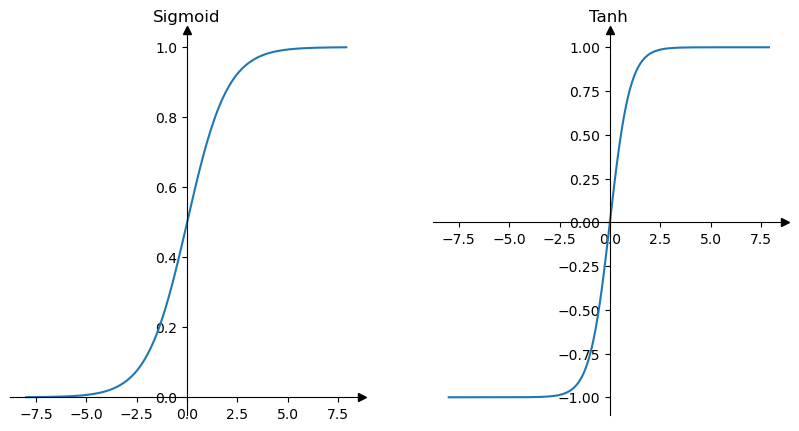

In [19]:
fig, axes=plt.subplots(1, 2,figsize=(10,5))

x=torch.arange(-8.0,8.0,0.1,requires_grad=True)
y_relu=x.sigmoid()
axes[0].plot(x.detach().numpy(), y_relu.detach().numpy(),label="ReLU")

y_tanh=x.tanh()
axes[1].plot(x.detach().numpy(), y_tanh.detach().numpy(),label="tanh")


axes[0].set_title('Sigmoid')
axes[1].set_title('Tanh')
usda_vis.plot_style_axis_A(axes[0])
usda_vis.plot_style_axis_A(axes[1])
plt.show()

**遗忘门：**

遗忘门的计算公式为$f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) $，式中$x_t$为时刻$t$时的输入；$h_{t-1}$为前一时刻的隐藏状态或时刻0时的初始状态；$W_{if}$、$W_{hf}$分别为输入值和隐藏状态的权重；$b_{if}$和$b_{hf}$为对应的偏置。遗忘门决定了哪些特征信息被保留，而哪些应该被忽略。输入特征和前一时刻的隐藏状态通过 Sigmoid 函数传递，映射到[0,1]区间。如果该值趋近于1，与前一时刻的单元状态$c_{t-1}$乘积会保持前一单元状态基本不变，意味着信息流通；否则趋近于0，意味着前一单元状态的特征信息被忽略。

**输入门：**

输入门计算为两部分的乘积，一部分同遗忘门，用于删选特征信息；另一部分为隐藏节点，对应公式分别为$i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi})$ 和$g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg})$。此时可以更新当前时刻$t$的单元状态为$c_t = f_t \odot c_{t-1} + i_t \odot g_t$，式中$\odot$为哈达玛积（Hadamard product），为两个矩阵对应元素相乘的结果。因此输入门通过更新单元状态将新的相关信息添加到了现有信息中。

**输出门**

输入门计算也为两部分的乘积，一部分为用于删选特征信息的 Sigmoid 函数，公式为$o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho})$；另一部分为更新的当前时刻的单元状态$c_t$。计算输出值公式为$h_t = o_t \odot \tanh(c_t)$。输出门更新了隐藏状态$h_t$，同单元状态$c_t$作为下一时刻的输入。

继续前文试验，将 RNN 替换为 LSTM，并增加单元状态初始张量$c0$，计算结果如下。

In [25]:
input_size=1
hidden_size=3
num_layers=1

rnn=nn.LSTM(input_size, hidden_size, num_layers)
print(rnn)
h0=torch.randn(num_layers, X.shape[1], hidden_size)
c0=torch.randn(num_layers, X.shape[1], hidden_size)
output, (hn,cn)=rnn(X, (h0,c0))
print(output.shape,hn.shape,cn.shape)
print(output,'\n','-'*50,'\n',hn,'\n',cn)

LSTM(1, 3)
torch.Size([1, 6, 3]) torch.Size([1, 6, 3]) torch.Size([1, 6, 3])
tensor([[[-0.2156,  0.2163, -0.2481],
         [-0.0974,  0.4490, -0.4016],
         [-0.4627, -0.1346, -0.2763],
         [-0.0875, -0.3300, -0.0779],
         [-0.2781,  0.0431, -0.1354],
         [-0.0718, -0.0208,  0.3109]]], grad_fn=<MkldnnRnnLayerBackward0>) 
 -------------------------------------------------- 
 tensor([[[-0.2156,  0.2163, -0.2481],
         [-0.0974,  0.4490, -0.4016],
         [-0.4627, -0.1346, -0.2763],
         [-0.0875, -0.3300, -0.0779],
         [-0.2781,  0.0431, -0.1354],
         [-0.0718, -0.0208,  0.3109]]], grad_fn=<StackBackward0>) 
 tensor([[[-0.3266,  0.4154, -0.4966],
         [-0.2703,  0.8698, -0.5718],
         [-0.6668, -0.3594, -0.5487],
         [-0.6161, -1.3928, -0.1051],
         [-0.5705,  0.0955, -0.3340],
         [-0.1111, -0.0466,  0.5318]]], grad_fn=<StackBackward0>)


### 3.6.1.3 LSTM 的文本生成试验

前文将`neural`作为一个示例样本序列传入 RNN（LSTM）模型，该模型能够捕获到`neural`的隐藏节点状态和单元状态，使用该状态输出作为学习到的特征可以用于序列数据的预测、分类等任务，例如语言建模和文本生成（Language Modelling & Generating Text）、语音识别（Speech Recognition）、生成图像描述（Generating Image Descriptions）或视频标记（Video Tagging）等<sup>[Schmidt, R. M. (2019). Recurrent Neural Networks (RNNs): A gentle Introduction and Overview. CoRR, abs/1912.05911. Retrieved from http://arxiv.org/abs/1912.05911]</sup>。用 LSTM 生成文本为例，实现数据集建立、模型构建、训练到文本生成<sup>[Text Generation with LSTM in PyTorch, <https://machinelearningmastery.com/text-generation-with-lstm-in-pytorch/>]</sup>。

In [97]:
%load_ext autoreload 
%autoreload 2 
import usda.data_visual as usda_vis    
import usda.utils as usda_utils
import usda.models as usda_models

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import os
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


* 建立序列数据集

文本数据为[Alice's Adventures in Wonderland by Lewis Carroll](https://www.gutenberg.org/ebooks/11)，将其转化为指定长度的序列数据集，包括建立字符到整数的映射编码`ebook_dataset.char_to_int`；按照指定长度切分文本为片段作为样本特征输入，并除以分类数标准化输入特征值；对应的（分类）标签为各序列片段紧邻的下一个跟随字符。例如对于文本`What a curious feeling!`（长度为23），如果给定切分长度为20，那么提取片段为`What a curious feeli`，对应的标签为`n`，并需转换为整数编码和标准化。

建立文本序列数据集的过程定义为`text2ints_encoded()`函数，直接调用计算。

In [2]:
filename='../data/Wonderland.txt'  
seq_length=100
ebook_dataset=usda_models.text2ints_encoded(filename,seq_length)
X=ebook_dataset.data
y=ebook_dataset.target
print(X.shape,y.shape)

Total Characters:  164047
Total Vocab:  64
Total Patterns:  163947
torch.Size([163947, 100, 1]) torch.Size([163947])


In [3]:
batch_size=128
loader=data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size) 

查看字符到整数的映射，和一个样本序列及其对应的标签。

In [45]:
print(ebook_dataset.char_to_int)
for X_batch,y_batch in loader:
    x=X_batch[0]
    y=y_batch[0]
    print(x[:5],y)    
    break

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, "'": 7, '(': 8, ')': 9, '*': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '?': 27, '[': 28, ']': 29, '_': 30, 'a': 31, 'b': 32, 'c': 33, 'd': 34, 'e': 35, 'f': 36, 'g': 37, 'h': 38, 'i': 39, 'j': 40, 'k': 41, 'l': 42, 'm': 43, 'n': 44, 'o': 45, 'p': 46, 'q': 47, 'r': 48, 's': 49, 't': 50, 'u': 51, 'v': 52, 'w': 53, 'x': 54, 'y': 55, 'z': 56, 'ù': 57, '—': 58, '‘': 59, '’': 60, '“': 61, '”': 62, '\ufeff': 63}
tensor([[0.0156],
        [0.6562],
        [0.7031],
        [0.7031],
        [0.6406]]) tensor(35)


* 建立 LSTM 网络模型

将 LSTM 计算时序片段（一个语境）的最后一个节点输出状态（包含有最多信息）作为全连接层的输入，全连接层的输出大小为分类数，其输出值可用 SoftMax 回归多分类函数转换为分类类标的概率分布（标准化到区间[0,1]，且总和为1），预测分类。

In [13]:
class CharModel(nn.Module):
    def __init__(self,n_vocab,input_size=1, hidden_size=256, num_layers=2, batch_first=True, dropout_lstm=0.2,dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first, dropout=dropout_lstm)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, n_vocab)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x

n_vocab=len(ebook_dataset.feature_names)
input_size=1
model=CharModel(n_vocab,input_size)
print(model)

CharModel(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=256, out_features=64, bias=True)
)


* 训练模型

定义`char_train()`函数，方便调用以实现模型训练。训练的模型保存到本地磁盘。

In [33]:
n_epochs=100
char_to_int=ebook_dataset.char_to_int
save_path='../models/ebook_lstm_model.pth'
usda_models.char_train(model,loader,n_epochs,char_to_int,save_path)

* 文本生成

定义`char_random_generation()`函数，调用已训练的模型，根据随机读取的文本片段逐次的预测下一个字符，例如下述示例的提示词最后几个单词为`choosing to notice`，预测的第一个字符为`a`，并将该字符追加到提示词中，且剔除提示词的第一个字符，用于下一个字符的预测，以此类推。

对于这个简单的示例模型，文本生成的结果虽然并不完美，但是验证了 LSTM 对序列数据建模预测的可行性。

In [86]:
model=usda_models.CharModel(n_vocab,input_size)
usda_models.char_random_generation(model,save_path,filename,seq_length=100,gen_length=1000)    

Prompt: "ell—eh, stupid?”

“but they were _in_ the well,” alice said to the dormouse, not choosing
to notice " 
 --------------------------------------------------
and broked. 
“i won’t ” said the caterpillar.

“well, perhaps your pardon!” said the king, “and the tuertion whol you coll the canst and the thing as ‘i get whan it is!”

“i whsh i had so say it any noneer than you can’t hear your majesty,” the mock turtle replied; “what i’s goingng not a perpents  and it is the coor with the things beal the reasenese!”

“i don’t think it would not gane iis the sea,” the mock turtle replied; “i’m a poor mittle sime ier any of the eiseations than it was, and the duchess to be a lettrn of the coorersation as the could goes the thatp with with the thing sealed to het on the trees she was not uhink the was not a little way off a little way
off a little way off a little way off a little way off a little wire iis gead with the thing sealed to het on the thatp, and she was now a little bootersation

### 3.6.1.4 原始（Vanilla） RNN 模型和 LSTM 模型捕获长期依赖关系的验证

Vanilla RNN 当前时刻的状态输出只与当前数据点输入和前一时刻的隐藏状态有关，而 LSTM 能够捕获前一时刻和更早时刻的状态，这一情况从下述打印的连续训练迭代周期预测曲线可以进一步得以验证<sup>[RNN in PyTorch (kaggle), https://www.kaggle.com/code/namanmanchanda/rnn-in-pytorch/notebook]</sup>。对于Vanilla RNN ，因为只考虑前一时刻隐藏状态，所以预测的值沿着前一隐藏状态和当前输入“顺势”求解；而 LSTM 因为引入了当前时刻之前较长跨度时间步的多个单元状态的信息，在开始的迭代周期，可以发现预测的曲线并不贴合到实际的值上，但是随着训练迭代的进行，预测曲线逐步拟合到实际值上。

* 定义数据集

建立一个符合正弦曲线的序列。

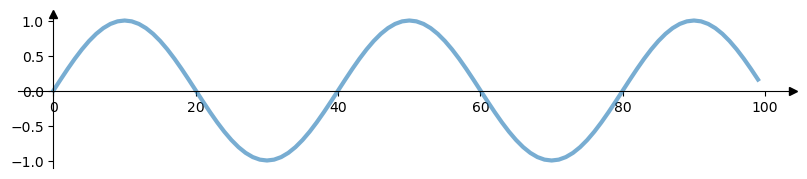

In [3]:
num=1000
x=torch.linspace(0,num-1,num)
period=40
y=torch.sin(x*2*np.pi/period)

fig, ax=plt.subplots(1, 1,figsize=(10,2))
ax.plot(x[:100],y[:100], lw=3, alpha=0.6)

usda_vis.plot_style_axis_A(ax)
plt.show()

类似文本生成部分的数据切分为序列片段的方法，给定切分长度获得多个序列片段，并以该片段紧邻的下一时刻的值为类标，按顺序连续叠合切分，定义`sequence2series_of_overlapping_with_labels()`函数实现。

In [4]:
test_size=100
train_set=y[:-test_size]
test_set=y[-test_size:]

window_size=period
train_data=usda_utils.sequence2series_of_overlapping_with_labels(train_set, window_size)
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9101e-01,  8.0902e-01,
          7.0711e-01,  5.8779e-01,  4.5399e-01,  3.0902e-01,  1.5643e-01,
         -8.7423e-08, -1.5643e-01, -3.0902e-01, -4.5399e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5106e-01, -8.9101e-01, -8.0902e-01,
         -7.0711e-01, -5.8779e-01, -4.5399e-01, -3.0902e-01, -1.5643e-01]),
 tensor([1.7485e-07]))

为了获得同一试验结果，固定随机种子。配置学习率$lr=0.01$。

In [10]:
torch.manual_seed(42)
lr=0.01

* Vannila RNN 模型

首先试验Vannila RNN 模型。定义试验模型时将 Vannila RNN 和 LSTM 定义在了同一类下，定义的类为`RNN_LSTM_sequence`，通过配置参数`selection='RNN'`指定为 Vannila RNN 模型。

RNN_LSTM_sequence(
  (rnn_lstm): RNN(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)
Epoch 0 Loss:8.481218173983507e-06; Performance on test range: 0.003869572188705206


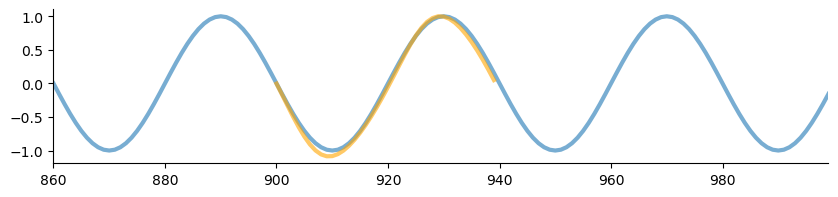

Epoch 1 Loss:1.535474984848406e-05; Performance on test range: 0.00407208688557148


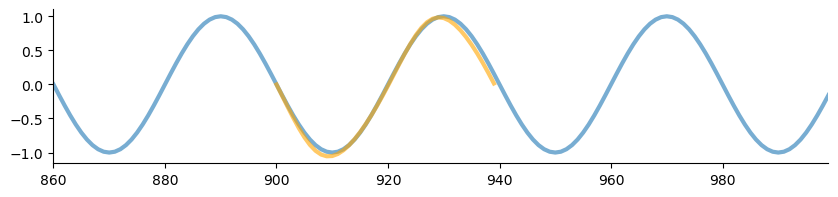

Epoch 2 Loss:1.4694256606162526e-05; Performance on test range: 0.0033605736680328846


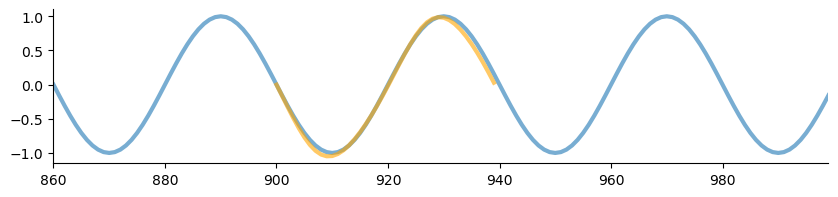

In [11]:
model=usda_models.RNN_LSTM_sequence(selection='RNN')
print(model)

criterion=nn.MSELoss()
optimizer=torch.optim.SGD(model.parameters(),lr=lr)
usda_models.RNN_LSTM_train_sequence(model,train_data,train_set,x,y,optimizer,criterion,window_size,test_size,epochs=3,future=40,plot=True)

* LSTM 模型

指定`selection='LSTM'`，分析 LSTM 模型训练迭代预测结果与实际值的变化关系。

RNN_LSTM_sequence(
  (rnn_lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)
Epoch 0 Loss:0.07350001484155655; Performance on test range: 0.574382483959198


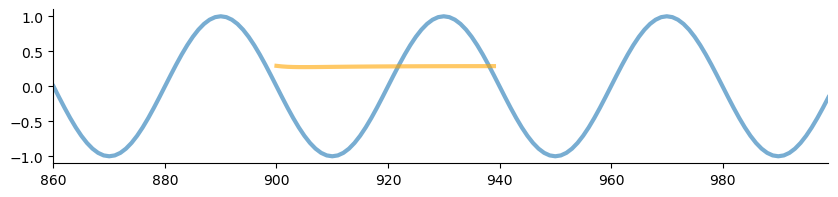

Epoch 1 Loss:0.030122658237814903; Performance on test range: 0.46689707040786743


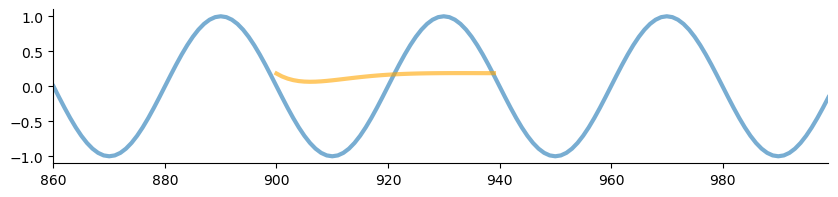

Epoch 2 Loss:0.002125221537426114; Performance on test range: 0.10097652673721313


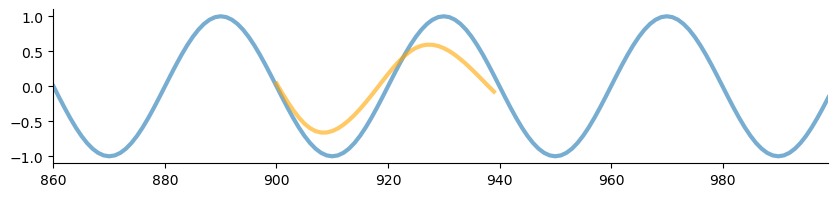

Epoch 3 Loss:0.00019723063451237977; Performance on test range: 0.0034082874190062284


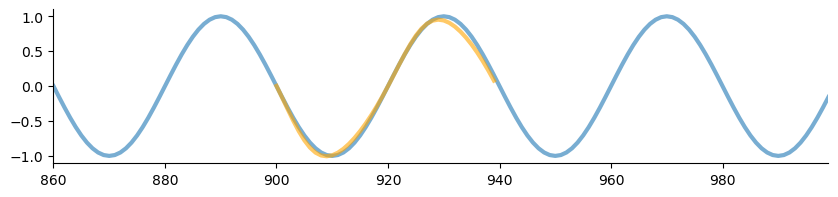

Epoch 4 Loss:0.00014400237705558538; Performance on test range: 0.002277107909321785


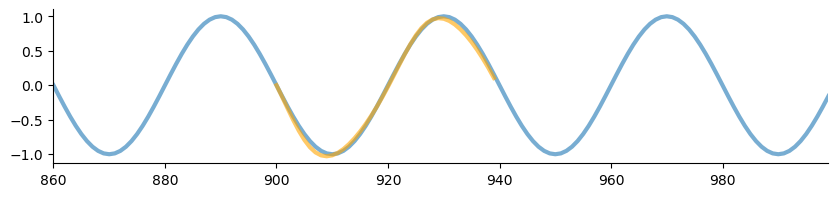

In [12]:
model=usda_models.RNN_LSTM_sequence(selection='LSTM')
print(model)

criterion=nn.MSELoss()
optimizer=torch.optim.SGD(model.parameters(),lr=lr)
usda_models.RNN_LSTM_train_sequence(model,train_data,train_set,x,y,optimizer,criterion,window_size,test_size,epochs=5,future=40,plot=True)

### 3.6.1.5 将图像（影像）看作一个空间序列 

可以把一个二维的图像（影像）沿一个轴向看作一个空间序列，输入特征的数量为另一个轴向的像素（单元）数，同样以最后一个隐藏状态作为全连接层的输入实现图像的分类任务<sup>[Recurrent Neural Network with Pytorch (kaggle), <https://www.kaggle.com/code/kanncaa1/recurrent-neural-network-with-pytorch/notebook>]</sup>。

* MNIST 手写体数字图片数据集准备

使用轻量型的 [MNIST 数据集](http://yann.lecun.com/exdb/mnist/)说明将图像看作一个空间序列进行分类识别的建模过程。

In [90]:
mnist_fn=r'I:\data\mnist'
traindt=datasets.MNIST(root = mnist_fn,transform=transforms.ToTensor(),train=True,download=True)
testdt=datasets.MNIST(root = mnist_fn,transform=transforms.ToTensor(),train=False,download=True)

In [94]:
print(traindt,'\n',testdt)
batch_size=100
train_loader=DataLoader(traindt, batch_size=batch_size, shuffle=False)
test_loader=DataLoader(testdt, batch_size=batch_size, shuffle=False)

Dataset MNIST
    Number of datapoints: 60000
    Root location: I:\data\mnist
    Split: Train
    StandardTransform
Transform: ToTensor() 
 Dataset MNIST
    Number of datapoints: 10000
    Root location: I:\data\mnist
    Split: Test
    StandardTransform
Transform: ToTensor()


打印查看一个样本。

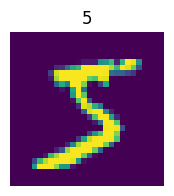

In [98]:
fig, ax=plt.subplots(1, 1,figsize=(2,2))
ax.imshow(traindt[0][0].numpy().reshape(28,28))
plt.axis("off")
plt.title(str(traindt[0][1]))
plt.show()

* 建立 Vallina RNN 模型

定义`RNN_model_img`类，为一个 Vallina RNN。因为图像的大小为$28 \times 28$，因此配置参数`input_dim=28`。而数字总共有10个，因此全连接层的输出维度为10。

In [100]:
n_iters=8000
num_epochs=int(n_iters/(len(traindt)/batch_size))
print(num_epochs)

# Create RNN
input_dim=28    # input dimension
hidden_dim=100  # hidden layer dimension
layer_dim=1 # number of hidden layers
output_dim=10   # output dimension

model=usda_models.RNN_model_img(input_dim, hidden_dim,layer_dim, output_dim,)
print(model)

# Cross Entropy Loss 
error=nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate=0.05
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)

13
RNN_model_img(
  (rnn): RNN(28, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)


* 模型训练

定义`RNN_train_img()`函数训练模型，并返回损失和准确率（精度）。

In [25]:
iteration_list,loss_list,accuracy_list=usda_models.RNN_train_img(model,train_loader,test_loader,input_dim,optimizer,error,epochs=num_epochs,step_eval=50) 

Iteration: 500  Loss: 0.9909659028053284  Accuracy: 76.11000061035156 %
Iteration: 1000  Loss: 0.6082250475883484  Accuracy: 84.36000061035156 %
Iteration: 1500  Loss: 0.7935434579849243  Accuracy: 87.54000091552734 %
Iteration: 2000  Loss: 0.24458648264408112  Accuracy: 92.19000244140625 %
Iteration: 2500  Loss: 0.0790989100933075  Accuracy: 93.0999984741211 %
Iteration: 3000  Loss: 0.21234281361103058  Accuracy: 92.87999725341797 %
Iteration: 3500  Loss: 0.24958306550979614  Accuracy: 94.06999969482422 %
Iteration: 4000  Loss: 0.18281689286231995  Accuracy: 94.80999755859375 %
Iteration: 4500  Loss: 0.27840670943260193  Accuracy: 89.4000015258789 %
Iteration: 5000  Loss: 0.18332625925540924  Accuracy: 94.76000213623047 %
Iteration: 5500  Loss: 0.049436092376708984  Accuracy: 96.48999786376953 %
Iteration: 6000  Loss: 0.21413767337799072  Accuracy: 96.08999633789062 %
Iteration: 6500  Loss: 0.12760573625564575  Accuracy: 96.44999694824219 %
Iteration: 7000  Loss: 0.09869009256362915  

打印损失和准确率曲线，可以观察到损失曲线随着训练迭代逐渐降低，而准确率不断爬升并趋于平缓，可以达到约 96% 的精度。

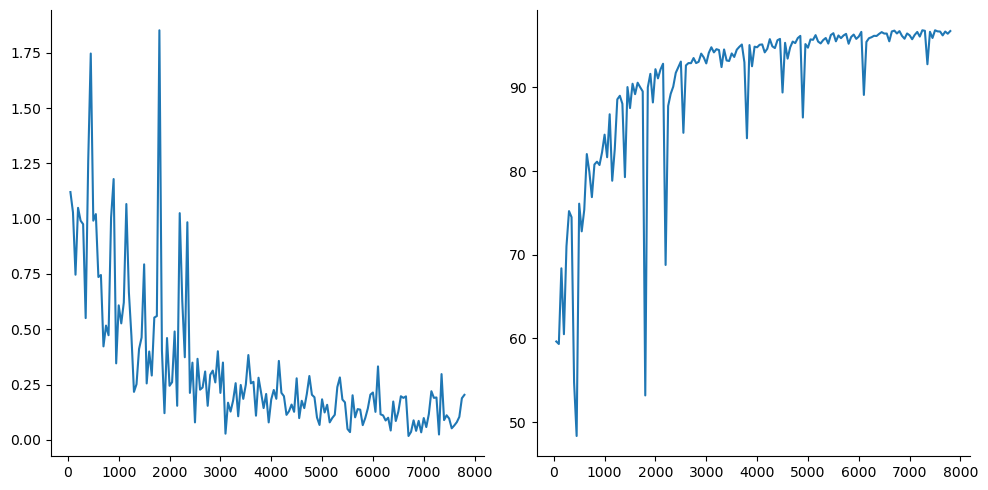

In [29]:
fig, axs=plt.subplots(1, 2,figsize=(10,5))
axs[0].plot(iteration_list,loss_list)
axs[1].plot(iteration_list,accuracy_list)

axes[0].set_title('Loss')
axes[1].set_title('Accuracy')
axs[0].spines[['right', 'top']].set_visible(False)
axs[1].spines[['right', 'top']].set_visible(False)
fig.tight_layout()
plt.show()            

## 3.6.2 Transformer——自然语言处理（Natural Language Processing，NLP）

相关参考阅读（按理解 Transformer 前置知识点次序）：

1. 词向量（Word Embeddings）：[The Illustrated Word2vec](https://jalammar.github.io/illustrated-word2vec/)；[An Intuitive Understanding of Word Embeddings: From Count Vectors to Word2Vec](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/)；[What Are Word Embeddings for Text?](https://machinelearningmastery.com/what-are-word-embeddings/)；[How to Develop Word Embeddings in Python with Gensim](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/)；[词向量 (Word Embeddings)](https://leovan.me/cn/2018/10/word-embeddings/)；[One-Hot, Label, Target and K-Fold Target Encoding, Clearly Explained!!!](https://www.youtube.com/watch?v=589nCGeWG1w)；[Word Embedding and Word2Vec, Clearly Explained!!!](https://www.youtube.com/watch?v=viZrOnJclY0)；[GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)；[Word2Vec Tutorial - The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)；[Word2vec with PyTorch: Implementing the Original Paper](https://towardsdatascience.com/word2vec-with-pytorch-implementing-original-paper-2cd7040120b0)

2. Seq2Seq（Sequence-to-sequence）/Encoder-Decoder：[Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention)](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)；[Sequence-to-Sequence (seq2seq) Encoder-Decoder Neural Networks, Clearly Explained!!!](https://www.youtube.com/watch?v=L8HKweZIOmg&t=829s)；

3. Transformer：[The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)；[Transformer: A Novel Neural Network Architecture for Language Understanding](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html)；[The Annotated Transformer](http://nlp.seas.harvard.edu/annotated-transformer/)；[Transformers and Multi-Head Attention](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial6/Transformers_and_MHAttention.html)

4. Vision Transformers：[Vision Transformers](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html)；[Attention? Attention!](https://lilianweng.github.io/posts/2018-06-24-attention/)；[The Transformer Family](https://lilianweng.github.io/posts/2020-04-07-the-transformer-family/)；


### 3.6.2.1 词向量（Word Embeddings）

#### 1) 文本矢量化

对文本数据分类、情感分析、文本生成和不同语言的翻译时，所用到的文本数据集并不能直接输入到模型进行训练，除常规数据预处理外，需要解析原始文本为小的语句块，分解为单词、句子等，称为标记化（tokenization）。标记化有助于理解语境（上下文），通过分析单词的顺序解释文本的含义；并将单词编码为整数或浮点值，称为特征提取或矢量化（vectorization）。标记化和矢量化文本数据有多种方式，基于频数的矢量化有词频向量（word count vectors）、TF-IDF向量、共现（Co-Occurrence）矩阵和哈希向量（Hashing vectors）等<sup>[Brownlee, J. (2017). Deep Learning for Natural Language Processing: Develop Deep Learning Models for your Natural Language Problems (1.1). Independently Published.]</sup>。可用[sklearn](https://scikit-learn.org/stable/)库提供的相应方法计算，如下示例。

In [71]:
%load_ext autoreload 
%autoreload 2 
import usda.models as usda_models

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from gensim.utils import tokenize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**A: 词频向量**

词频向量构建方式如下图，提取输入文本的唯一一个或多个（n 元语法）单词/字符作为词汇表（标记化），根据词汇表列表对位索引计数或统计词频（矢量化）。

<img src="../imgs/3_6/3_6_08.jpg" height='auto' width=600 title="caDesign"> 

* n-gram （n-元语法）

参数`ngram_range`是指从文本中提取单词或者字符的上下边界，例如`(1,1)`意味仅含一元语法（unigrams），`(1,2)`意味包含一元语法和二元语法（bigrams），`(2,2)`则仅包含二元语法，依次类推到多元语法，例如三元语法（trigram）。

仅含一元语法。

In [37]:
countVectorizer_print=lambda vectorizer,X: print(f'------------volcab\n{vectorizer.vocabulary_}\
                                                 \n------------feature\n{vectorizer.get_feature_names_out()}\
                                                 \n------------stop words\n{vectorizer.get_stop_words()}\
                                                 \n------------array\n{X.toarray()}')

corpus=['This is the first document.', 
       'This document is the second document.',
       'And this is the third one.']
vectorizer=CountVectorizer(analyzer='word')
X=vectorizer.fit_transform(corpus)
countVectorizer_print(vectorizer,X)

------------volcab
{'this': 8, 'is': 3, 'the': 6, 'first': 2, 'document': 1, 'second': 5, 'and': 0, 'third': 7, 'one': 4}                                                 
------------feature
['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']                                                 
------------stop words
None                                                 
------------array
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]]


含一元和二元语法。

In [3]:
vectorizer=CountVectorizer(analyzer='word',ngram_range=(1, 2))
X=vectorizer.fit_transform(corpus)
countVectorizer_print(vectorizer,X)

------------volcab
{'this': 17, 'is': 6, 'the': 11, 'first': 4, 'document': 2, 'this is': 19, 'is the': 7, 'the first': 12, 'first document': 5, 'second': 9, 'this document': 18, 'document is': 3, 'the second': 13, 'second document': 10, 'and': 0, 'third': 15, 'one': 8, 'and this': 1, 'the third': 14, 'third one': 16}                                                 
------------feature
['and' 'and this' 'document' 'document is' 'first' 'first document' 'is'
 'is the' 'one' 'second' 'second document' 'the' 'the first' 'the second'
 'the third' 'third' 'third one' 'this' 'this document' 'this is']                                                 
------------stop words
None                                                 
------------array
[[0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1]
 [0 0 2 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 0]
 [1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 1 0 1]]


仅含二元语法。

In [4]:
vectorizer=CountVectorizer(analyzer='word',ngram_range=(2, 2))
X=vectorizer.fit_transform(corpus)
countVectorizer_print(vectorizer,X)

------------volcab
{'this is': 10, 'is the': 3, 'the first': 5, 'first document': 2, 'this document': 9, 'document is': 1, 'the second': 6, 'second document': 4, 'and this': 0, 'the third': 7, 'third one': 8}                                                 
------------feature
['and this' 'document is' 'first document' 'is the' 'second document'
 'the first' 'the second' 'the third' 'third one' 'this document'
 'this is']                                                 
------------stop words
None                                                 
------------array
[[0 0 1 1 0 1 0 0 0 0 1]
 [0 1 0 1 1 0 1 0 0 1 0]
 [1 0 0 1 0 0 0 1 1 0 1]]


* 过滤掉停用词（Stop Words）

停用词是那些对短语（phrase）的深层含义没有帮助的词，为最常见的单词，例如the、a、is 等。因此对于一些模型，例如文档分类等，则删除这些停顿词有益于模型训练。可以用`Sklearn`库提供的`get_stop_words`方法查看停用词，也可以用[NLTK](https://www.nltk.org/)库`stopwords`方法查看。

In [65]:
corpus_motto=['Do the best you can until you know better. Then when you know better, do better.— Maya Angelou', 
      'Your time is limited so don’t waste it living someone else’s life. – Steve Jobs',
      'Don’t be pushed by your problems. Be led by your dreams. – Ralph Waldo Emerson']
vectorizer=CountVectorizer(analyzer='word',ngram_range=(1, 1),stop_words='english')
X=vectorizer.fit_transform(corpus_motto)
countVectorizer_print(vectorizer,X)

------------volcab
{'best': 1, 'know': 7, 'better': 2, 'maya': 12, 'angelou': 0, 'time': 17, 'limited': 10, 'don': 3, 'waste': 19, 'living': 11, 'life': 9, 'steve': 16, 'jobs': 6, 'pushed': 14, 'problems': 13, 'led': 8, 'dreams': 4, 'ralph': 15, 'waldo': 18, 'emerson': 5}                                                 
------------feature
['angelou' 'best' 'better' 'don' 'dreams' 'emerson' 'jobs' 'know' 'led'
 'life' 'limited' 'living' 'maya' 'problems' 'pushed' 'ralph' 'steve'
 'time' 'waldo' 'waste']                                                 
------------stop words
frozenset({'anyway', 'both', 'hereupon', 'too', 'had', 'further', 'side', 'although', 'against', 'describe', 'cry', 'but', 'seeming', 'still', 'full', 'twelve', 'ten', 'its', 'hers', 'hence', 'along', 're', 'system', 'back', 'off', 'without', 'itself', 'beside', 'over', 'own', 'therefore', 'where', 'herself', 'nevertheless', 'about', 'from', 'somewhere', 'next', 'am', 'whoever', 'nowhere', 'latter', 'nobody', 'thick

用`NLTK`库查看停用词。

In [81]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words=stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\richi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**B: TF-IDF向量**

如果不过滤掉停用词，那么在计数向量的方法中，像 the、is、will等词出现的次数较多，且在编码向量中没有太大的意义，而TF-IDF（term Frequency - Inverse Document Frequency ）向量方法，一种用于信息检索与数据挖掘的常用加权技术，能够改善上述情况。其中 TF（词频） 表示为给定字词$t$在文档$d$中出现的频数，可表示为$tf(t,d)$；IDF 为逆文本频率指数，减小跨文档出现次数较多的字词影响，可表示为$idf(t)=log[n/(df(t)+1)]$，（在`Sklearn`库中，为$idf(t)=log[n/df(t)]+1$，如果配置参数`smooth_idf=True`，则为$idf(t)=log[(1+n)/(1+df(t))]+1$），式中，$n$为文档总数，$df(t)$为字词$t$在一个文档中的频数。将上述两部分相乘，得$tf-idf(t,d)=tf(t,d) \times idf(t)$。

下述示例中可以看到词`countvectorizer`和`Tf-idf`的值为0.6330，而 this、is、about 等词值为0.448，要小于前者。

In [80]:
corpus_vector=['This is about CountVectorizer',
        'This is about Tf-idf']
vectorizer=TfidfVectorizer(analyzer='word',token_pattern=r"(?u)\S\S+")
X=vectorizer.fit_transform(corpus_vector)
print(vectorizer.get_feature_names_out())
print(X.toarray())

['about' 'countvectorizer' 'is' 'tf-idf' 'this']
[[0.44832087 0.63009934 0.44832087 0.         0.44832087]
 [0.44832087 0.         0.44832087 0.63009934 0.44832087]]


**C: 共现（Co-Occurrence）矩阵**

相似的词往往会一起出现，并会有相似的语境，例如'Apple is a fruit'和'Mango is a fruit'等，因此统计给定语境窗口（Context Window），元素（字词，短语、句子，任何感兴趣的语言单元）共同出现的次数可以表述语料库元素间的关系。定义`build_co_occurrence_matrix()`函数计算共现矩阵。配置参数`window_size=10`，大于单个句子的最大长度，是以整个句子为最小的语境窗口进行统计。

In [69]:
corpus_fruit=['Apple is a fruit','Mango is a fruit','Mango tastes sweet and sour']
coo_dict,coo_df=usda_models.build_co_occurrence_matrix(corpus_fruit,window_size=10)
coo_df

,a,Apple,fruit,sour,Mango,and,tastes,sweet,is
a,0,1,2,0,1,0,0,0,2
Apple,1,0,1,0,0,0,0,0,1
fruit,2,1,0,0,1,0,0,0,2
sour,0,0,0,0,1,1,1,1,0
Mango,1,0,1,1,0,1,1,1,1
and,0,0,0,1,1,0,1,1,0
tastes,0,0,0,1,1,1,0,1,0
sweet,0,0,0,1,1,1,1,0,0
is,2,1,2,0,1,0,0,0,0


**D: 哈希/散列向量（Hashing vectors）**

词频向量、TF-IDF权重向量和共现矩阵等方法随着语料库的扩大，词汇表可能变得非常大，这将需要大量的向量来编码文档，对计算机的内存和算力提出要求。解决上述问题的一种途径是使用哈希向量映射或降维。

* 哈希函数（Hash function）<sup>[Hashing in Data Structure: What, Types, and Functions, <https://www.knowledgehut.com/blog/programming/hashing-in-data-structure>][Hash function (Wikipedia), <https://en.wikipedia.org/wiki/Hash_function>]</sup>

哈希函数是可以把任意大小的数据映射到固定大小值的函数（有些哈希函数也支持可变长度的输出）。哈希函数返回的值称为哈希值（hash values）、哈希码（hash codes）、摘要（digests）或简称哈希（hashes）。这些值通常用于索引一个称为哈希表（hash table）的固定大小的表。使用哈希函数对哈希表进行索引称为哈希（hashing）或者分散存储寻址（scatter storage addressing）。在数据存储和检索等应用程序中，哈希函数及其关联的哈希表可以在每次检索时以很小且几乎恒定的时长访问数据；并且所需的存储空间仅略大于数据或者记录本身所需要的总空间。哈希是一种高效计算和空间存储的数据访问形式，避免了无序列表和结构化树的非恒定访问时长，及直接访问大型或具有可变长度键状态空间时对存储空间成指数级的需求。

<img src="../imgs/3_6/3_6_09.jpg" height='auto' width=400 title="caDesign"> 

上图 A 和 B 例举了两种哈希函数形式，其中 A 为一个余数表示；B 为键的长度表示。哈希函数的形式（算法）有多种，但都有一个相同的原则，将数据映射到一个可以索引数组的值。一些流行的哈希算法有SHA-1、MD5和Murmur Hash等。在图 C 中，一个哈希函数将键（人名）映射到0到15的一个整数形式，且有两个键映射到同一个哈希值02的位置上，该种情况适合于某些应用场景，达到合并降维的目的。

`HashingVectorizer`方法即为哈希向量，在第一个示例代码中，词汇表有8个词，配置输出矩阵特征列的数量参数`n_features=10`，不会发生映射碰撞/冲突（ collision），为哈希映射；第二个示例代码中，有29个词，同样配置`n_features=10`，则有部分特征发生了合并降维。

---哈希映射

In [91]:
corpus2tokens=lambda corpus: [[word for word in tokenize(sentence) if word not in stopwords.words('english')] for sentence in corpus]

vectorizer=HashingVectorizer(n_features=10,stop_words='english',norm=None)
X=vectorizer.fit_transform(corpus_fruit)
print(corpus2tokens(corpus_fruit))
print(f'{type(X)}\n{X}\n{X.toarray()}')

[['Apple', 'fruit'], ['Mango', 'fruit'], ['Mango', 'tastes', 'sweet', 'sour']]
<class 'scipy.sparse._csr.csr_matrix'>
  (0, 0)	1.0
  (0, 3)	1.0
  (1, 1)	1.0
  (1, 3)	1.0
  (2, 0)	1.0
  (2, 1)	1.0
  (2, 4)	-2.0
[[ 1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0. -2.  0.  0.  0.  0.  0.]]


---哈希合并

In [92]:
vectorizer=HashingVectorizer(n_features=10,stop_words='english',norm='l2')
X=vectorizer.fit_transform(corpus_motto)
print(corpus2tokens(corpus_motto))
print(f'{type(X)}\n{X}\n{X.toarray()}')

[['Do', 'best', 'know', 'better', 'Then', 'know', 'better', 'better', 'Maya', 'Angelou'], ['Your', 'time', 'limited', 'waste', 'living', 'someone', 'else', 'life', 'Steve', 'Jobs'], ['Don', 'pushed', 'problems', 'Be', 'led', 'dreams', 'Ralph', 'Waldo', 'Emerson']]
<class 'scipy.sparse._csr.csr_matrix'>
  (0, 1)	-0.23570226039551587
  (0, 4)	-0.47140452079103173
  (0, 7)	-0.47140452079103173
  (0, 8)	-0.7071067811865476
  (1, 1)	-0.4082482904638631
  (1, 2)	-0.4082482904638631
  (1, 3)	-0.4082482904638631
  (1, 4)	-0.4082482904638631
  (1, 6)	0.4082482904638631
  (1, 8)	0.4082482904638631
  (2, 0)	0.6324555320336759
  (2, 3)	0.6324555320336759
  (2, 5)	0.0
  (2, 6)	0.31622776601683794
  (2, 7)	0.31622776601683794
[[ 0.         -0.23570226  0.          0.         -0.47140452  0.
   0.         -0.47140452 -0.70710678  0.        ]
 [ 0.         -0.40824829 -0.40824829 -0.40824829 -0.40824829  0.
   0.40824829  0.          0.40824829  0.        ]
 [ 0.63245553  0.          0.          0.632

#### 2）距离度量——Cosine similarity 和词嵌入（Word Embeddings）

词频向量、TF-IDF向量等方法仅记录了文档中对应词汇表字词的频数所呈现字词数量分布的特征，并没有体现出哪些词的组合更容易构成具有意义的短语或句子，及哪些词在给定语境下更相似，例如‘Apple finally announced its long-rumored AR/VR headset, called the VisionPro.’和‘Some of the best-tasting apple varieties are Honeycrisp, Pink Lady, Fuji, Ambrosia, and Cox's Orange Pippin.’，在第一个语境下，apple 与VisionPro等词更容易组成有意义的句子，而第二个语境，apple 与 tasting、Cox等词更容易组合。虽然共现矩阵的方法可以统计给定切分窗口字词共同出现的次数，但是矩阵的大小为词汇表长度的2次方，而多维向量的距离度量方法（可以查看*标记距离*一章的距离度量）可以指定特征维数，例如常用的50、100或者300等。在 Word2Vec 方法中使用了 Cosine 距离（Cosine Similarity，CS）<sup>[Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space. arXiv [Cs.CL]. Retrieved from http://arxiv.org/abs/1301.3781]</sup>，CS 的计算公式为$S_{\operatorname{Cos}}=\frac{\sum_{i=1}^d P_i Q_i}{\sqrt{\sum_{i=1}^d P_i^2} \sqrt{\sum_{i=1}^d Q_i^2}}$ （`PyTorch`库给出的公式为：$\text{similarity} = \dfrac{x_1 \cdot x_2}{\max(\Vert x_1 \Vert _2 \cdot \Vert x_2 \Vert _2, \epsilon)}$）。`PyTorch`提供了`torch.nn.CosineSimilarity(dim=1, eps=1e-08)`方法计算 CS。

参考 Jay Alammar 对 Word2Vec方法的解释和提供的案例<sup>[The Illustrated Word2vec, <https://jalammar.github.io/illustrated-word2vec/>]</sup>，假设有3个地点（或区域）为 loc_0,loc_1 和 loc_2，各计算有5个生态服务指数（假设区间含正负值），为碳存储、生境质量、降温指数、年产水和自然空间可达性等，现在需要比较基于这5个特征向量 备选地点 loc_1 和 loc_2 到 原地点 loc_0 的距离，即备选的哪个地点的特征更与原地点相近。为了方便图形可视化，先选择两个指数，假如为碳存储和生境质量，将这两个指数作为二维空间中的两个垂直坐标绘制特征点，并计算备选点到原地点的 CS 值。

In [23]:
%load_ext autoreload 
%autoreload 2 
import usda.pattern_signature as usda_signature
import usda.data_visual as usda_vis 
import usda.utils as usda_utils
import usda.models as usda_models

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import math
from varname import nameof

import gensim
import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.utils import tokenize

from nltk.corpus import stopwords
import nltk
from sklearn.manifold import TSNE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


从计算结果可以观察到，备选地点到原地点的距离分别为0.868和-0.210，其中 loc_1 与 loc_0 相对更为相似。 

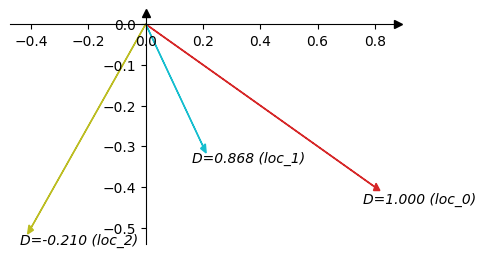

In [288]:
cosine_similarity=nn.CosineSimilarity(dim=0, eps=1e-6)

origin=torch.tensor([0,0],dtype=torch.float64)
location_0=torch.tensor([0.8,-0.4],dtype=torch.float64)
location_1=torch.tensor([0.2,-0.3],dtype=torch.float64)
location_2=torch.tensor([-0.4,-0.5],dtype=torch.float64)
location_dict={'loc_0':location_0,'loc_1':location_1,'loc_2':location_2}
colors=['tab:red','tab:cyan','tab:olive']

fig, ax=plt.subplots(figsize=(5,3))
i=0
for key,loc in location_dict.items():
    distance=cosine_similarity(location_0,loc)
    ax.arrow(*origin,*loc,head_width=0.02, head_length=0.02,color=colors[i])
    ax.text(*loc-0.04,f'D={distance:.3f} ({key})',fontstyle='italic')
    i+=1

usda_vis.plot_style_axis_A(ax)
plt.show()

计算所有5个维度的特征距离，loc_1 到 loc_0 的距离为 0.658，而loc_2 到 loc_0 的距离为-0.368。通过不同空间地点给定多维度特征的距离计算，说明该种方法可以用于时空序列，如自然语言处理（Natural language processing，NLP）能够反映词汇表字词间距离的特征向量；如果对应到空间数据则可以理解为城市空间不同区域间反映属性距离的特征向量；对应到时序数据则可以理解为不同样本间属性距离的特征向量。

In [272]:
location_0=torch.tensor([0.8,-0.4,0.5,-0.2,0.3],dtype=torch.float64)
location_1=torch.tensor([0.2,-0.3,0.3,-0.4,0.9],dtype=torch.float64)
location_2=torch.tensor([-0.4,-0.5,-0.2,0.7,-0.1],dtype=torch.float64)

print(f'D(0-1)={cosine_similarity(location_0,location_1)};\nD(0-2)={cosine_similarity(location_0,location_2)}')

D(0-1)=0.658233707531176;
D(0-2)=-0.3683509554826695


将上述案例对特征距离的解释对应到自然语言处理任务中的词嵌入（为了说明 word embedding 的特殊性，用“词嵌入”的翻译代替“词向量”的翻译），词嵌入可以通过 Word2Vec、GloVe 等模型算法从语料库中学习。先看下已经训练好的词嵌入，一般常用到已经训练好的词嵌入模型有 [Google 的 Word2Vec 的词嵌入](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g)和[斯坦福大学（Stanford） 的 GloVe 词嵌入](https://github.com/stanfordnlp/GloVe)。[gensim](https://radimrehurek.com/gensim/)库也已经集成了10多个已经训练好的[词嵌入模型](https://github.com/RaRe-Technologies/gensim-data)，下述示例下载的为`glove-wiki-gigaword-50`，基于的数据集为维基百科数据（Wikipedia 2014 + Gigaword 5 (6B tokens, uncased)），含有 40 万单词和短语，词嵌入的维度为 50。

通过`model["king"]`方式可以直接查看输入词对应的词嵌入向量。通过`model.most_similar('king')`方法可以获取与输入词距离最近的单词，例如与 king 词最近似的词有 prince, queen 等。

In [7]:
model=api.load('glove-wiki-gigaword-50')
print(model.vector_size)
print(model["king"])
print(model.most_similar('king'))

50
[ 0.50451   0.68607  -0.59517  -0.022801  0.60046  -0.13498  -0.08813
  0.47377  -0.61798  -0.31012  -0.076666  1.493    -0.034189 -0.98173
  0.68229   0.81722  -0.51874  -0.31503  -0.55809   0.66421   0.1961
 -0.13495  -0.11476  -0.30344   0.41177  -2.223    -1.0756   -1.0783
 -0.34354   0.33505   1.9927   -0.04234  -0.64319   0.71125   0.49159
  0.16754   0.34344  -0.25663  -0.8523    0.1661    0.40102   1.1685
 -1.0137   -0.21585  -0.15155   0.78321  -0.91241  -1.6106   -0.64426
 -0.51042 ]
[('prince', 0.8236179351806641), ('queen', 0.7839043140411377), ('ii', 0.7746230363845825), ('emperor', 0.7736247777938843), ('son', 0.766719400882721), ('uncle', 0.7627150416374207), ('kingdom', 0.7542160749435425), ('throne', 0.7539913654327393), ('brother', 0.7492411136627197), ('ruler', 0.7434253692626953)]


为了方便查看不同词嵌入向量的关系，打印向量值的热力图。50维的向量每一维度表征字词的某一特征（每一维度特征可解释的内容属性本文并未做探索），可以发现单词 king、man、woman、queen，及`king-man+woman`的向量运算结果中，有值明显接近的维度特征，例如蓝紫（25列和47列）和橘红（30列）等。

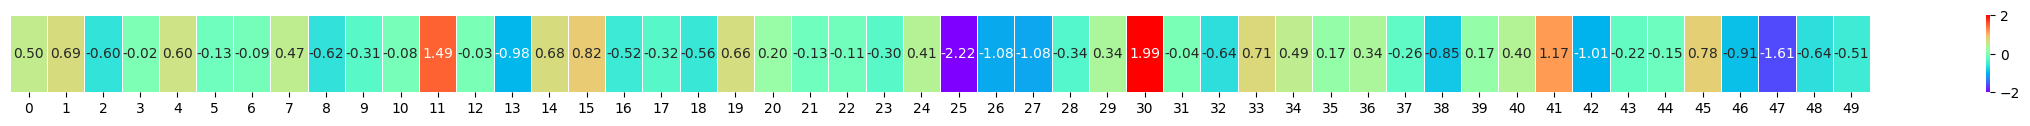

In [359]:
plt.figure(figsize=(30,1))
ax=sns.heatmap([model["king"]], xticklabels=True, yticklabels=False, cbar=True,vmin=-2, vmax=2, linewidths=0.7,cmap='rainbow',annot=True,fmt='.2f')
plt.show()     

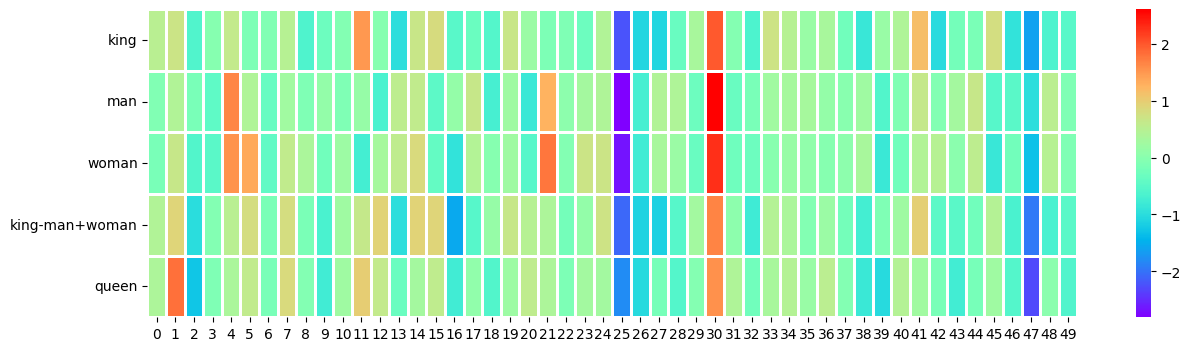

In [363]:
plt.figure(figsize=(15,4))
ax=sns.heatmap([model["king"], 
             model["man"], 
             model["woman"], 
             model["king"] - model["man"] + model["woman"],
             model["queen"],
            ], cbar=True, xticklabels=True, yticklabels=True,linewidths=1,cmap='rainbow') 

ax.set_yticks(np.arange(0.5,5))
ax.set_yticklabels(["king","man","woman","king-man+woman","queen"],rotation=0)
plt.show()

通过上述示例，引用相关文献对词嵌入的描述有，词嵌入是对文本的学习表示，具有相同、相近含义的字词通常具有相似的表示<sup>[Brownlee, J. (2017). Deep Learning for Natural Language Processing: Develop Deep Learning Models for your Natural Language Problems (1.1). Independently Published.]115</sup>。因为大多数神经网络工具包不能很好的处理高维（high-dimensional）、稀疏（sparse）向量，因此密集（dense）且低维(low-dimensional)的向量则更具有优势，并具有泛化能力<sup>[Goldberg, Y. (2017). Neural Network Methods for Natural Language Processing. Synthesis Lectures on Human Language Technologies, 1–309.]92</sup>。词嵌入将每个词映射到一个预定义的向量空间，表示为实值向量。通过神经网络学习语料库，训练词嵌入向量值。向量通常为数十到数百维，与数千到数百万维的稀疏向量（例如独热编码（one hot encoding））相比要小的多。

#### 3）词嵌入查找表（lookup table）

一个词汇表列表中各字词按照索引对应各自的词嵌入向量，为了方便通过词汇表索引提取对应的词嵌入向量，`PyTorch`提供了`torch.nn.Embedding`方法建立一个词嵌入的查找表。`Embedding`输入参数`num_embeddings`为词汇表的大小，参数`embedding_dim`为词嵌入向量的维度（其它参数配置可以查看 PyTorch 手册）。为了说明查找表的使用，这里使用前文`corpus_motto`的文本，但是去除了在已训练的`glove-wiki-gigaword-50`词嵌入模型中查找不到的人名等词。并不移除停用词，建立的词汇表有30个词语。

In [40]:
corpus_motto=['Do the best you can until you know better. Then when you know better, do better.',  # — Maya Angelou
              'Your time is limited so don’t waste it living someone else’s life. ', # – Steve Jobs
              'Don’t be pushed by your problems. Be led by your dreams.'] #  – Ralph Waldo Emerson

corpus2tokens=lambda corpus: [[word.lower() for word in tokenize(sentence)] for sentence in corpus] # if word not in stopwords.words('english')
corpus_tokens=corpus2tokens(corpus_motto)
vocab=np.unique(usda_utils.flatten_lst(corpus_tokens))
vocab_size=len(vocab)
print(f'{vocab}\nvocab size={vocab_size}')

['be' 'best' 'better' 'by' 'can' 'do' 'don' 'dreams' 'else' 'is' 'it'
 'know' 'led' 'life' 'limited' 'living' 'problems' 'pushed' 's' 'so'
 'someone' 't' 'the' 'then' 'time' 'until' 'waste' 'when' 'you' 'your']
vocab size=30


如果将字词转换成对应词汇表的索引，`gensim`库提供了`Dictionary`方法。

In [50]:
dct=Dictionary([vocab])
corpus_0=torch.LongTensor([dct.doc2idx([word])[0] for word in corpus_tokens[0]]) 
print(corpus_tokens[0])
print(corpus_0)

['do', 'the', 'best', 'you', 'can', 'until', 'you', 'know', 'better', 'then', 'when', 'you', 'know', 'better', 'do', 'better']
tensor([ 5, 22,  1, 28,  4, 25, 28, 11,  2, 23, 27, 28, 11,  2,  5,  2])


`nn.Embedding`初始化的词嵌入向量为随机值，通过神经网络学习语料库后各词的嵌入向量才能够表征语境下词汇之间的距离。这里直接提取已训练的`glove-wiki-gigaword-50`词嵌入向量中`corpus_motto`文本词汇表对应的向量覆盖随机初始化值，仅用于说明查找表的使用。用建立的查找表`embedding`查找`corpus_0[0]`，即词`do`，可以看到其查询结果同`glove-wiki-gigaword-50`中的查询结果。

In [59]:
vocab_embeddings=model[vocab]
print(vocab_embeddings.shape)

embedding=nn.Embedding(vocab_size, vocab_embeddings.shape[1])
embedding.weight=nn.Parameter(torch.from_numpy(vocab_embeddings))
print(model['do'])
print(embedding(corpus_0[0]))

(30, 50)
[ 2.9605e-01 -1.3841e-01  4.3774e-02 -3.8744e-01  1.2262e-01 -6.5180e-01
 -2.8240e-01  9.0312e-02 -5.5186e-01  3.2060e-01  3.7422e-03  9.3229e-01
 -2.2034e-01 -2.1922e-01  9.2170e-01  7.5724e-01  8.4892e-01 -4.2197e-03
  5.3626e-01 -1.2667e+00 -6.1028e-01  1.6700e-01  8.2753e-01  6.5765e-01
  4.8959e-01 -1.9744e+00 -1.1490e+00 -2.1461e-01  8.0539e-01 -1.4745e+00
  3.7490e+00  1.0141e+00 -1.1293e+00 -5.2661e-01 -1.2029e-01 -2.7931e-01
  6.5092e-02 -4.3639e-02  6.0426e-01 -2.0892e-01 -4.5739e-01  1.0441e-02
  4.1458e-01  6.8900e-01  1.4468e-01 -3.1973e-02 -4.8073e-02 -1.1279e-04
  1.3854e-01  9.6954e-01]
tensor([ 2.9605e-01, -1.3841e-01,  4.3774e-02, -3.8744e-01,  1.2262e-01,
        -6.5180e-01, -2.8240e-01,  9.0312e-02, -5.5186e-01,  3.2060e-01,
         3.7422e-03,  9.3229e-01, -2.2034e-01, -2.1922e-01,  9.2170e-01,
         7.5724e-01,  8.4892e-01, -4.2197e-03,  5.3626e-01, -1.2667e+00,
        -6.1028e-01,  1.6700e-01,  8.2753e-01,  6.5765e-01,  4.8959e-01,
        -1.9744e

#### 4) Word2Vec

以Mikolov, T.等人 2013 年发表的两篇论文<sup>[Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space. arXiv [Cs.CL]. Retrieved from http://arxiv.org/abs/1301.3781][Mikolov, T., Sutskever, I., Chen, K., Corrado, G., & Dean, J. (2013). Distributed Representations of Words and Phrases and their Compositionality. arXiv [Cs.CL]. Retrieved from http://arxiv.org/abs/1310.4546]</sup>为主，参考实现该论文方法的代码实现<sup>[implementation of word2vec Paper, <https://www.kaggle.com/code/ashukr/implementation-of-word2vec-paper>]</sup>，解释学习语料库估计词嵌入的方法。根据给定窗口语境下输入词（X）和输出词(y)的相对位置，文中描述了两类结构模型，一个称为 CBOW（Continuous Bag-of-Words），另一个称为 Skip-gram。如图 <sup>[Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space. arXiv [Cs.CL]. Retrieved from http://arxiv.org/abs/1301.3781]</sup>

<img src="../imgs/3_6/3_6_10.png" height='auto' width=600 title="caDesign"> 

例如对于 'Efﬁcient Estimation of Word Representations in Vector Space' 这个短语（不区分大小写，含停用词），如果以词`word`为输出$w(t)$，以`word`邻近指定长度的词为输入，如`Estimation`即$w(t-2)$、`of`即$w(t-1)$加上`Representations`即$w(t+1)$、` in`即$w(t+2)$，则该种结构模型为 CBOW；如果以词`word`为输入，而以邻近指定长度的词为输出，例如`Estimation`、`of`加上`Representations`、`in`（同 CBOW 的输入），则该种结构模型为 Skip-gram，又如下图，标识了中心词和语境的概念。

<img src="../imgs/3_6/3_6_12.png" height='auto' width=600 title="caDesign"> 

因此选择的模型不同，构建数据集所配置的输入（解释变量）$X$和输出（结果变量）`y`不同。因为 Skip-gram 结构模型表现要好于 CBOW，因此代码示例选择 Skip-gram 模型，其公式表示为$\frac{1}{T} \sum_{t=1}^T \sum_{-c \leq j \leq c, j \neq 0} \log p\left(w_{t+j} \mid w_t\right)$，式中，$c$为训练语境（上下文）窗口大小（可以是中心词$w_t$的函数），较大的值$c$产生更多的训练样本，从而获得更高的准确率，但训练时间也会增加。

在 Skip-gram 结构中，给定窗口大小，根据输入词预测该词语境下对应每个输出词有一个输出预测向量，为词汇表每个单词的概率，这意味着对数据集中的每一个训练样本执行一次就很容易达到数千万次的计算量。为了解决计算量问题，Mikolov, T.等人提出了 Negative Sampling（NEG）方法，首先将对输出词对应词汇表的概率分布预测调整为应用逻辑回归（Logistic Regression, LR）的二分类（类标为值1或0）问题，公式为$ p\left(w_O \mid w_I\right)=\frac{\exp \left(v_{w_O}^{\prime}{ }^{\top} v_{w_I}\right)}{\sum_{w=1}^W \exp \left(v_w^{\prime}{ }^{\top} v_{w_I}\right)}$，式中，$v_w$和$v_w^{\prime}$为$w$的输入和输出的词向量，$W$为词汇表中的单词数。把给定窗口语境下输入词的邻近词（neighbors）赋值为1，而把非邻近词（not neighbours）赋值为0，这种方式计算简单而快捷。不过，在给定的窗口语境下，邻近词均为1，预测的结果将是100%的正确，并没有从语料库中学习到任何有价值的信息，因此需要填补这个漏洞，从词汇表中采样赋值为0的非邻近的字词加入数据样本中，就是 NEG 方法，从而将任务设定为使用逻辑回归从噪声分布$P_n(w)$中区分目标单词$w_O$，其中每个数据样本有$k$个负样本（值为0），公式为$\log \sigma\left(v_{w_O}^{\prime}{ }^{\top} v_{w_I}\right)+\sum_{i=1}^k \mathbb{E}_{w_i \sim P_n(w)}\left[\log \sigma\left(-v_{w_i}^{\prime}{ }^{\top} v_{w_I}\right)\right] $。根据试验，对于小的训练数据集，采样大小$k$推荐区间为5-20；对于较大的数据集推荐区间为2-5。噪声分布对应代码为：

```python
def noise_dist4sgns(freqs):
    word_freqs = np.array(sorted(freqs.values(), reverse=True))
    unigram_dist = word_freqs/word_freqs.sum()
    noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

    return noise_dist
```

通过`noise_dist4sgns()`函数获得噪声分布`noise_dist`后，执行`noise_words = torch.multinomial(noise_dist,batch_size * n_samples,replacement=True)`从输入张量（`noise_dist`）相应行的多项概率分布中采样，返回给定数量的索引值。

在非常大的语料库中，最常见的单词很容易出现数亿次之多，例如 in、the 和 a 等，通常这些词提供的信息价值不如罕见词，例如 France 和 Paris等。为了解决罕见词和频繁词之间的不平衡，使用一种简单的抽样方法，根据公式$P\left(w_i\right)=1-\sqrt{\frac{t}{f\left(w_i\right)}}$ 计算的概率，丢弃训练数据集中$w_i$的每个词，式中$f(w_i)$为字词$w_i$的频数；$t$为一个删选阈值。对应代码为：

```python
def subsampling_of_frequent_words(int_words,threshold=1e-5):
    word_counts = Counter(int_words)
    total_count = len(int_words)
    freqs = {word: count/total_count for word, count in word_counts.items()}
    p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
    
    train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]
    
    return train_words,freqs
```

使用的数据集为[text8 - word embedding](https://www.kaggle.com/datasets/gupta24789/text8-word-embedding)，为来自维基百科经过清洗的前 10  亿个字符数据。读取该数据，得知总共字词数约为 1668万，词汇表大小约为 6 万。

>  `gensim`库提供有[Word2vec](https://radimrehurek.com/gensim/models/word2vec.html)方法，可以直接调用计算

In [6]:
text_fn=r'I:\data\text8'
with open(text_fn) as f:
    text=f.read()
print(text[:100])

words=usda_models.text_replace_preprocess(text)
print(words[:10])
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) 

 anarchism originated as a term of abuse first used against early working class radicals including t
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
Total words in text: 16680599
Unique words: 63641


根据词频概率进行降采样。

In [7]:
vocab_to_int, int_to_vocab = usda_models.create_lookup_tables4vocab(words)
int_words = [vocab_to_int[word] for word in words]
print(int_words[:10])
train_words,freqs=usda_models.subsampling_of_frequent_words(int_words)
print(train_words[:10])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155]
[5233, 3080, 194, 3133, 127, 10571, 27349, 15067, 58112, 3580]


建立用于 Skip-gram 结构的数据集，可以看到字词（整数索引） `5233` 对应着邻近的3个词 `[3080, 194, 3133]`，以此类推。

In [9]:
batch_size=4
X,y=next(usda_models.get_batches4word2vec(train_words,batch_size))
print(X,y)

[5233, 5233, 5233, 3080, 3080, 3080, 194, 194, 3133] [3080, 194, 3133, 5233, 194, 3133, 3080, 3133, 194]


定义神经网络时，创建两个矩阵，一个为输入词嵌入矩阵，另一个为输出词嵌入矩阵。词嵌入矩阵维度为`(vocab_size,embedding_size)`，`vocab_size`为词汇表的大小，`embedding_size`为词嵌入向量大小（例如常用 300 大小），如图<sup>[The Illustrated Word2vec, <https://jalammar.github.io/illustrated-word2vec/>]</sup>。

<img src="../imgs/3_6/3_6_11.png" height='auto' width=800 title="caDesign"> 

在训练开始，用随机值初始化两个词嵌入矩阵。在迭代学习过程，对每一个样本输入，例如有输入词 not，和上下文邻近的词 thou（对应实际标签 `target` 的值为1），并用 NEG 方法采样了两个非邻近词 aaron 和 taco（对应实际标签 `target` 的值为0），通过对应随机初始化的两个嵌入矩阵查找输入词和输出词的词嵌入向量。取输入词和各输出词嵌入向量的点积（`input ● output`列），结果为一个数值，表示输入词嵌入和上下文词嵌入的相似性。用逻辑回归，`sigmoid()`函数将值转化为概率，获得预测，然后计算误差值用于梯度下降法更新开始随机生成的两个词嵌入矩阵。对应代码如下：

```python
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        # define embedding layers for input and output words
        self.in_embed = nn.Embedding(n_vocab,n_embed)
        self.out_embed = nn.Embedding(n_vocab,n_embed)
        
        # Initialize both embedding tables with uniform distribution
        self.in_embed.weight.data.uniform_(-1,1)
        self.out_embed.weight.data.uniform_(-1,1)
        
    def forward_input(self, input_words):
        # return input vector embeddings
        input_vector = self.in_embed(input_words)
        return input_vector
    
    def forward_output(self, output_words):
        # return output vector embeddings
        output_vector = self.out_embed(output_words)

        return output_vector
    
    def forward_noise(self, batch_size, n_samples,device):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        if self.noise_dist is None:
            # Sample words uniformly
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist
            
        # Sample words from our noise distribution
        noise_words = torch.multinomial(noise_dist,
                                        batch_size * n_samples,
                                        replacement=True)

        noise_words = noise_words.to(device)
        
        ## TODO: get the noise embeddings
        # reshape the embeddings so that they have dims (batch_size, n_samples, n_embed)
        # as we are adding the noise to the output, so we will create the noise vectr using the
        # output embedding layer
        noise_vector = self.out_embed(noise_words).view(batch_size,n_samples,self.n_embed)        
        return noise_vector
```

用`SkipGramNeg`类初始化模型为`model`，并定义`NegativeSamplingLoss`类，初始化损失（可从 `USDA` 库查看源代码）`criterion`，和用`Adam`为优化函数。

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
noise_dist =usda_models.noise_dist4sgns(freqs)

# instantiating the model
embedding_dim=300
model = usda_models.SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)  
print(f'model:\n{model}')        

# using the loss that we defined
criterion = usda_models.NegativeSamplingLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

model:
SkipGramNeg(
  (in_embed): Embedding(63641, 300)
  (out_embed): Embedding(63641, 300)
)


定义`sgns_train()`函数训练模型，并将模型参数保持值本地磁盘。

In [ ]:
save_path=r'I:\model_ckpts\word2vec\sgns_model.pth'
usda_models.sgns_train(model,criterion,optimizer,train_words,int_to_vocab,device=device,save_path=save_path,print_every = 1000)

上述训练了10个迭代，从结果来看，语义相近的词嵌入向量的距离开始减小，例如对于词`ice`相近的词预测有`frozen`、`snow`、`temperatures`等，这符合语料库语句搭配的常识。下面调用训练模型参数，查看结果。

In [16]:
save_path=r'I:\model_ckpts\word2vec\sgns_model.pth'
checkpoint=torch.load(save_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

SkipGramNeg(
  (in_embed): Embedding(63641, 300)
  (out_embed): Embedding(63641, 300)
)

每一个词嵌入向量有 300 维，通过`Sklearn`库提供的`TSNE`方法降维。`TSNE`是一个高维数据可视化工具，将数据点之间的相似性（距离）转换为联合概率并试图最小化低维嵌入和高维数据联合概率之间的 Kullback-Leibler 散度（divergence）<sup>[sklearn.manifold.TSNE, <https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html>]</sup>。 从下述打印结果可以观察到，词嵌入向量间的距离越小，数据点越相互靠近，表明这些词具有更多的相似性。

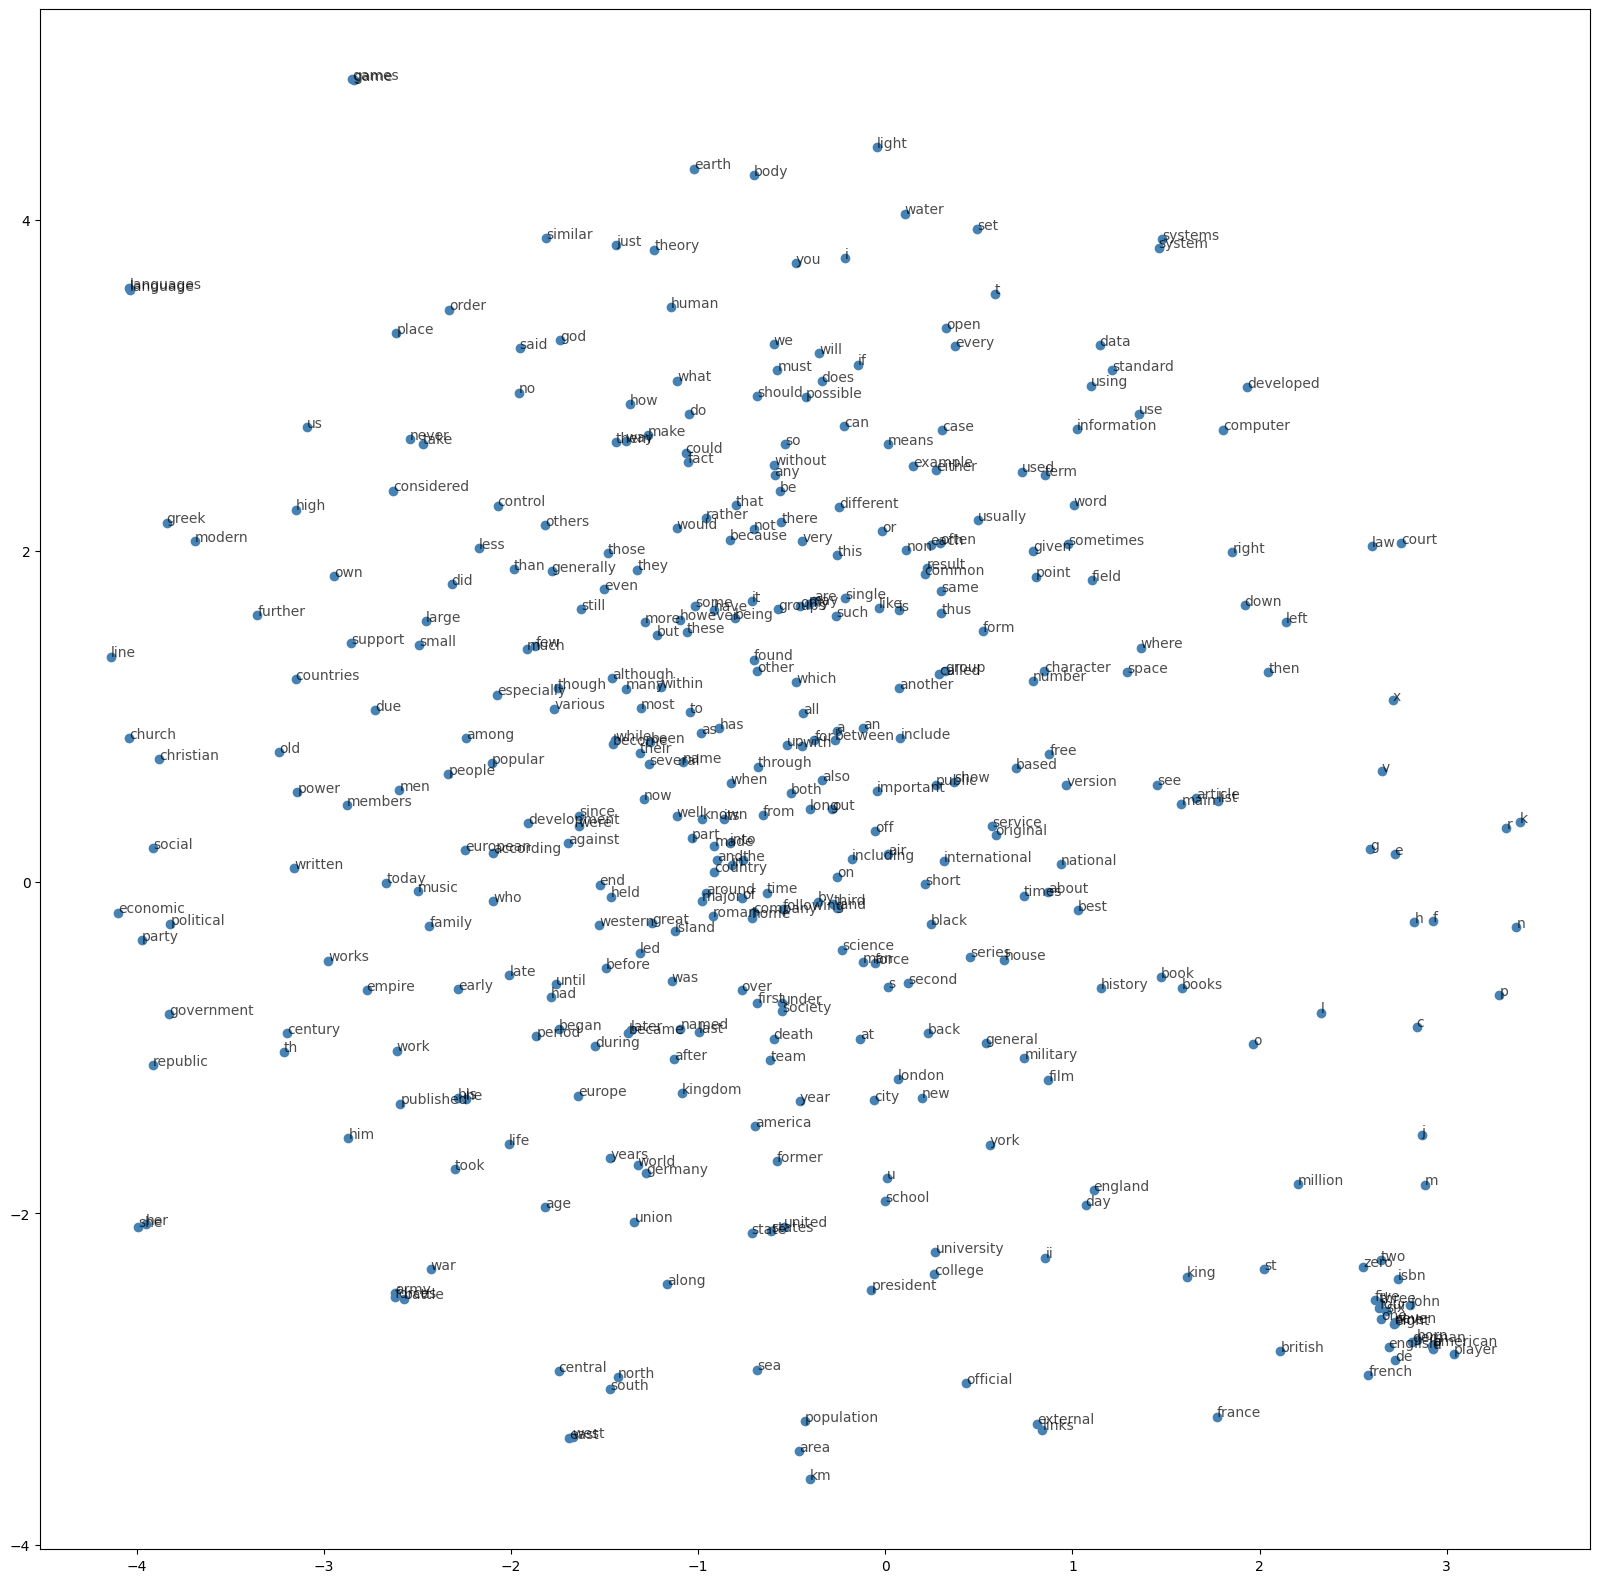

In [20]:
embeddings = model.in_embed.weight.to('cpu').data.numpy()
viz_words = 380
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

fig, ax = plt.subplots(figsize=(20, 20))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

#### 5) Seq2Seq